In [1]:
import pandas as pd
import time
from urllib.parse import urlparse, parse_qs
import math
import statistics
from pandasql import sqldf
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'Downloads/congress_stock_Transactions_cleaned.csv')

df['TransactionAmount'] = df['TransactionAmount'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df["Min_TransactionAmount"] = df["TransactionAmount"].apply(lambda x: min(x))
df['Performance'] = pd.to_numeric(df['Performance'].str.replace('%', ''), errors='coerce') / 100
df['Positive_Performance'] = (df['Performance'] > 0).astype(int)


In [17]:
df[df["Transaction_Year"] == 2023]["Ticker"].sum()

df[(df["Transaction_Year"] == 2023) & (df["TransactionType"] == "Purchase")]["Min_TransactionAmount"].sum()

68068426.95

# Which Senators make the most trades year over year

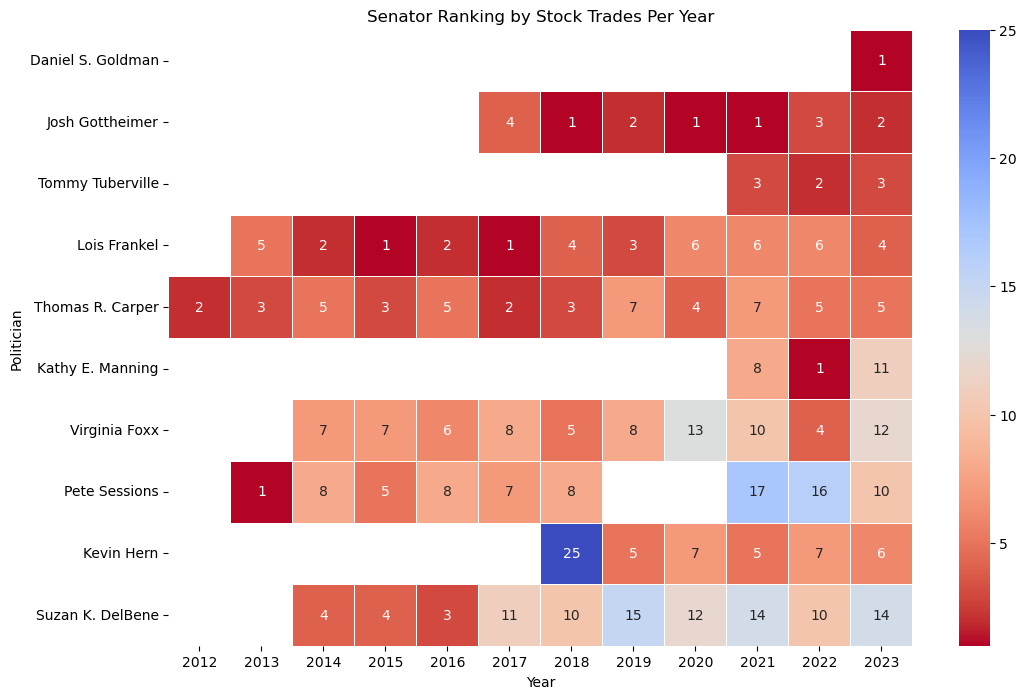

In [3]:
# Question 1

senator_purchase_activity = df.groupby(["PoliticianName", "Transaction_Year"]).agg(
    Transaction_Count = ("Ticker", "count")
).sort_values(by = ["Transaction_Year", "Transaction_Count"], ascending = [True, False]).reset_index()

n = 100

top_senators_trades = pd.DataFrame()
top_n_per_year = []

#n = top_senators_trades["PoliticianName"].nunique()

unique_years = senator_purchase_activity["Transaction_Year"].unique()

for year in unique_years:
    # Get the top n senators for the year
    top_for_year = senator_purchase_activity[senator_purchase_activity["Transaction_Year"] == year].sort_values(by="Transaction_Count", ascending=False).head(n)
    
    # Assign ranks
    top_for_year['Rank'] = range(1, len(top_for_year) + 1)
    
    top_n_per_year.append(top_for_year)

# Concatenate all the DataFrames in the list
top_senators_trades = pd.concat(top_n_per_year, ignore_index=True)

top_n = 10

# Creating a pivot table for the heatmap
top_senators_trades_pivot = top_senators_trades.pivot_table(index='PoliticianName', columns='Transaction_Year', values='Rank')


# Calculate the average rank for each politician
top_senators_trades_pivot['Average_Rank'] = top_senators_trades_pivot.mean(axis=1)

# Sort the DataFrame based on the average rank
top_senators_trades_pivot.sort_values('Average_Rank', ascending=True, inplace=True)

top_senators_trades_pivot = top_senators_trades_pivot.head(top_n)

# Remove the average rank column before plotting (if you don't want to show it in the heatmap)
top_senators_trades_pivot = top_senators_trades_pivot.drop(columns=['Average_Rank'])


# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_senators_trades_pivot, annot=True, cmap='coolwarm_r', linewidths=.5)
plt.title('Senator Ranking by Stock Trades Per Year')
plt.xlabel('Year')
plt.ylabel('Politician')
plt.show()


# Which Congresspeople have made the most all time trades

In [4]:
all_time_trades =  df.groupby(["PoliticianName"]).agg(
    Transaction_Count = ("Ticker", "count"),
    Trading_Years = ("Transaction_Year", "nunique"),
    Minimum_Volume = ("Min_TransactionAmount", "sum")
).sort_values(by = ["Transaction_Count"], ascending = [False]).reset_index()

all_time_trades.iloc[:,:3].head(10)

,PoliticianName,Transaction_Count,Trading_Years
0,Josh Gottheimer,2483,7
1,Lois Frankel,1542,11
2,Thomas R. Carper,1393,12
3,Daniel S. Goldman,1293,1
4,Susie Lee,1267,5
5,Tommy Tuberville,1049,3
6,Virginia Foxx,881,10
7,Katherine M. Clark,765,10
8,Kevin Hern,749,6
9,Sheldon Whitehouse,719,10


# Which Congressspeople have traded the most volume all time

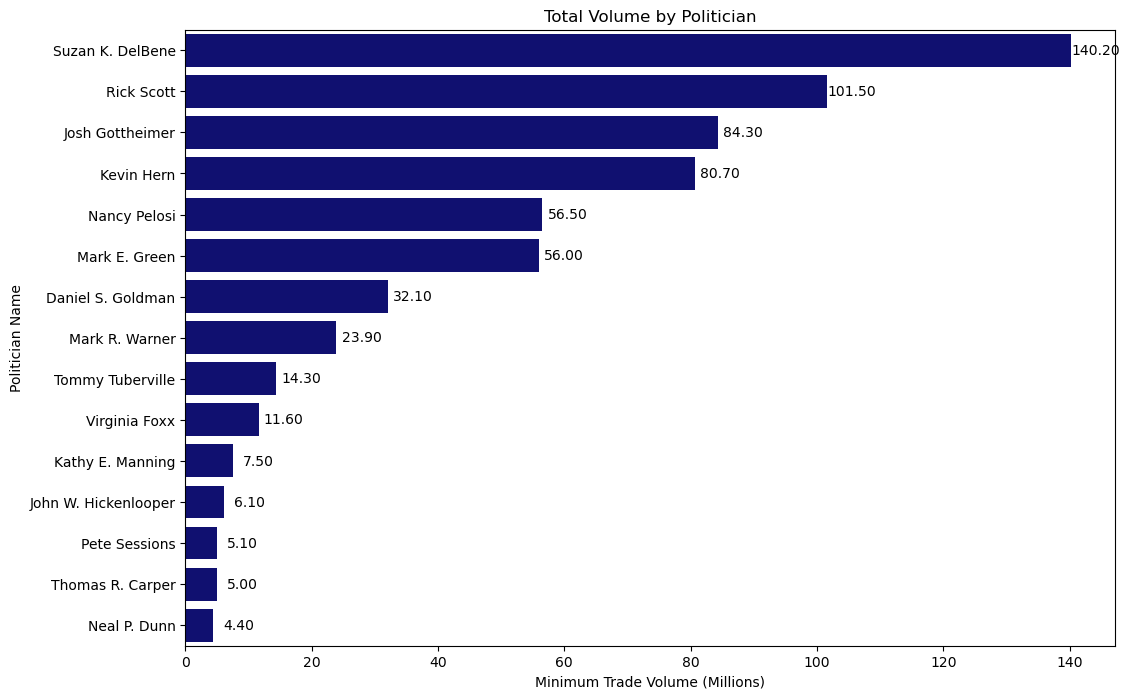

In [5]:
top_n = 15
plt.figure(figsize = (12,8))

all_time_trades.head()

all_time_trades['Volume (Millions)'] = round(all_time_trades['Minimum_Volume'] / 1000000,1)

ax = sns.barplot(data = all_time_trades.sort_values(by = 'Minimum_Volume', ascending = False).head(top_n),  y = 'PoliticianName', x = 'Volume (Millions)', color = 'navy' )

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width()+4, p.get_y() + p.get_height() / 2), ha='center', va='center', fontsize=10, color='black')


plt.title('Total Volume by Politician')
plt.ylabel('Politician Name')
plt.xlabel('Minimum Trade Volume (Millions)')

plt.show()

# What Percent of congress purchases are outperforming the SnP 500 today

# How has this changed Year over Year

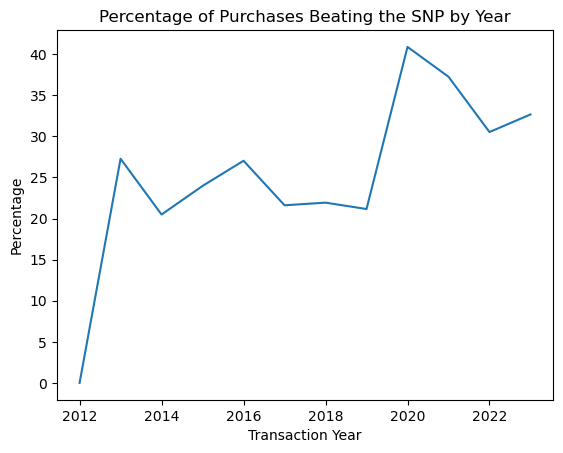

In [7]:
# Calculate the count of positive performance purchases by year
positive_performance_by_year = df[df["TransactionType"] == "Purchase"].groupby("Transaction_Year")["Positive_Performance"].sum()

# Calculate the total count of purchases by year
total_purchases_by_year = df[df["TransactionType"] == "Purchase"].groupby("Transaction_Year")["Positive_Performance"].count()

# Calculate the percentage of purchases beating the SNP by year
percentage_by_year = (positive_performance_by_year / total_purchases_by_year) * 100

# Create a line chart
percentage_by_year.plot(kind='line')
plt.title('Percentage of Purchases Beating the SNP by Year')
plt.xlabel('Transaction Year')
plt.ylabel('Percentage')
plt.show()

In [27]:
df.head()

all_time_senator_purchase_agg = df[df["TransactionType"] == "Purchase"].groupby(["PoliticianName"]).agg(
    First_Trading_Year = ("Transaction_Year", "min"),
    Active_Tradeing_Years = ("Transaction_Year", "nunique"),
    Total_Trade_Volume = ("Min_TransactionAmount", "sum"),
    Total_Transactions = ("Ticker", "count"),
    Avg_Performance = ("Performance", "mean"),
    Winning_Trades = ("Positive_Performance", "sum")
)
all_time_senator_purchase_agg['Transaction_Year'] = 'All'
all_time_senator_purchase_agg['TransactionType'] = 'Purchase'


yrly_senator_purchase_agg = df[df["TransactionType"] == "Purchase"].groupby(["PoliticianName", "Transaction_Year"]).agg(
    First_Trading_Year = ("Transaction_Year", "min"),
    Active_Tradeing_Years = ("Transaction_Year", "nunique"),
    Total_Trade_Volume = ("Min_TransactionAmount", "sum"),
    Total_Transactions = ("Ticker", "count"),
    Avg_Performance = ("Performance", "mean"),
    Winning_Trades = ("Positive_Performance", "sum")
)

yrly_senator_purchase_agg['TransactionType'] = 'Purchase'

result = pd.concat([ all_time_senator_purchase_agg.reset_index(), yrly_senator_purchase_agg.reset_index()])

result["Percent_Winner"] = (result["Winning_Trades"] / result["Total_Transactions"]).round(4)

# How many trades did Daneil Goldman and Josh Gottheimer combine for in 2023

In [29]:
result[result["Transaction_Year"] == 2023].sort_values(by = "Total_Transactions", ascending = False).head(10)

,PoliticianName,First_Trading_Year,Active_Tradeing_Years,Total_Trade_Volume,Total_Transactions,Avg_Performance,Winning_Trades,Transaction_Year,TransactionType,Percent_Winner
36,Daniel S. Goldman,2023,1,8430376.0,376,-0.118735,95,2023,Purchase,0.2527
116,Josh Gottheimer,2023,1,15503253.0,253,0.069894,140,2023,Purchase,0.5534
326,Tommy Tuberville,2023,1,2295171.0,171,0.035180,74,2023,Purchase,0.4327
169,Markwayne Mullin,2023,1,2488138.0,138,0.016397,62,2023,Purchase,0.4493
135,Kevin Hern,2023,1,3669088.0,88,-0.042579,29,2023,Purchase,0.3295
317,Thomas R. Carper,2023,1,655081.0,81,-0.134162,11,2023,Purchase,0.1358
156,Lois Frankel,2023,1,61061.0,61,-0.072382,21,2023,Purchase,0.3443
339,Virginia Foxx,2023,1,77049.0,49,-0.100651,5,2023,Purchase,0.1020
177,Michael Guest,2023,1,342048.0,48,-0.009922,15,2023,Purchase,0.3125
299,Suzan K. DelBene,2023,1,6461043.0,43,NaN,0,2023,Purchase,0.0000


In [30]:
result[result["Transaction_Year"] == 2023].sort_values(by = "Percent_Winner", ascending = False).head(10)

,PoliticianName,First_Trading_Year,Active_Tradeing_Years,Total_Trade_Volume,Total_Transactions,Avg_Performance,Winning_Trades,Transaction_Year,TransactionType,Percent_Winner
26,Dan Crenshaw,2023,1,1001.0,1,0.004300,1,2023,Purchase,1.0000
323,Tina Smith,2023,1,200003.0,3,0.272667,3,2023,Purchase,1.0000
329,Victoria Spartz,2023,1,47005.0,5,0.125980,5,2023,Purchase,1.0000
200,Morgan McGarvey,2023,1,3003.0,3,0.501100,3,2023,Purchase,1.0000
62,Dwight Evans,2023,1,3003.0,3,0.266900,2,2023,Purchase,0.6667
162,Mark E. Green,2023,1,880008.0,8,0.485467,5,2023,Purchase,0.6250
199,Mitch McConnell,2023,1,54005.0,5,0.042950,3,2023,Purchase,0.6000
116,Josh Gottheimer,2023,1,15503253.0,253,0.069894,140,2023,Purchase,0.5534
109,Jonathan L. Jackson,2023,1,367024.0,24,-0.007170,13,2023,Purchase,0.5417
129,Kathy E. Manning,2023,1,145032.0,32,0.027983,16,2023,Purchase,0.5000


# Which Congresspeople have the highest Percent of winning Transactions

In [9]:
result[(result["Transaction_Year"] == "All") & (result["Total_Transactions"] > 10)].sort_values(by = "Percent_Winner", ascending = False).head(10)

,PoliticianName,First_Trading_Year,Active_Tradeing_Years,Total_Trade_Volume,Total_Transactions,Avg_Performance,Winning_Trades,Transaction_Year,TransactionType,Percent_Winner
32,Mark E. Green,2020,4,27708477.0,477,0.502069,380,All,Purchase,0.7966
64,Victoria Spartz,2021,3,740016.0,16,0.051300,11,All,Purchase,0.6875
7,Dan Sullivan,2018,5,104041.0,41,0.503083,28,All,Purchase,0.6829
24,Jonathan L. Jackson,2023,1,367024.0,24,-0.007170,13,All,Purchase,0.5417
8,Daniel Meuser,2020,1,110026.0,26,0.059923,14,All,Purchase,0.5385
12,Deborah K. Ross,2021,1,278019.0,19,-0.060211,10,All,Purchase,0.5263
5,Dan Crenshaw,2020,4,21021.0,21,0.091567,10,All,Purchase,0.4762
6,Dan Newhouse,2021,3,51051.0,51,0.095273,24,All,Purchase,0.4706
36,Michael C. Burgess,2021,3,427035.0,35,-0.044380,16,All,Purchase,0.4571
34,Markwayne Mullin,2017,2,2588139.0,139,0.016397,62,All,Purchase,0.4460


# How do ALL active congresspeople stack up to the SnP 500 (all time)

(senators with over 10 transactions)

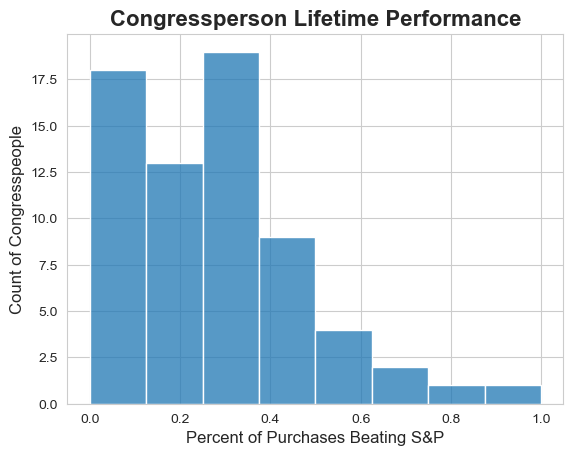

In [46]:
hist_data = result[(result["Transaction_Year"] == "All") & (result["Total_Transactions"] > 1)]

# Set the style
sns.set_style("whitegrid")

# Plot the histogram
sns.histplot(hist_data["Percent_Winner"])
plt.title("Congressperson Lifetime Performance", fontsize=16, fontweight='bold')
plt.xlabel("Percent of Purchases Beating S&P", fontsize=12)
plt.ylabel("Count of Congresspeople", fontsize=12)
plt.show()

In [44]:
hist_data[hist_data["Percent_Winner"] > .25]["PoliticianName"].nunique()

34

In [45]:
hist_data_cy = result[(result["Transaction_Year"] == 2023) & (result["Total_Transactions"] > 1)]

hist_data_cy[hist_data_cy["Percent_Winner"] > .25]["PoliticianName"].nunique()

30